In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision

import tensorflow as tf
import random

In [ ]:
import sys
sys.path.append('../../')

from utils.DataLoader import load_data

cols_to_drop = ['text', 'advanced_text', 'policy', 'antibiotics', 'self_empl', 'days_at_home', 
                'text_hist', 'text_phys_exam', 'advanced_text_hist','advanced_text_phys_exam',
                'phys_emb', 'adv_hist_emb', 'adv_phys_emb',
               ]

train_df, test_df = load_data(
    train_path='../../data/train_8000_final.p',
    test_path='../../data/test_2000_final.p',
    cols_to_drop=cols_to_drop
)

0-0    6057
0-1    1856
1-0      56
1-1      31
Name: count, dtype: int64


In [9]:
def NN_model_train(target, df_train, df_test, emb='hist_emb'):
    
    # Chuyển embeddings từ dạng list thành numpy array
    X_train = np.array(df_train.iloc[:, :12].drop(columns=target, errors='ignore'))
    X_test = np.array(df_test.iloc[:, :12].drop(columns=target, errors='ignore'))

    X_train = np.concatenate([X_train, df_train[emb].tolist()], axis=1)
    X_test = np.concatenate([X_test, df_test[emb].tolist()], axis=1)

    y_train = df_train[target].values  # Đảm bảo y_train là numpy array
    y_true = df_test[target].values  

    print("y_train shape:", y_train.shape)
    print("X_train: ", X_train.shape[1])
    # Định nghĩa model
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='relu')
    ])

    # Chọn loss function
    loss = 'binary_crossentropy'
    model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])
    
    model.summary()

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {0: class_weights[0], 1: class_weights[1]}

    print("Class Weights:", class_weights)

    # Huấn luyện mô hình
    model.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, class_weight=class_weights)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Bước 5: Tính ROC và PR Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    return model, roc_auc, fpr, tpr, recall, precision

y_train shape: (8000,)
X_train:  779


C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9176 - loss: 0.6641 - val_accuracy: 0.9319 - val_loss: 0.2521
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8961 - loss: 0.4150 - val_accuracy: 0.9731 - val_loss: 0.1344
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9541 - loss: 0.9403 - val_accuracy: 0.9456 - val_loss: 0.2758
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7938 - loss: 0.7351 - val_accuracy: 0.9250 - val_loss: 0.3604
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8648 - loss: 0.4090 - val_accuracy: 0.9331 - val_loss: 0.2823
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9320 - loss: 0.3236 - val_accuracy: 0.8994 - val_loss: 0.3664
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7664 - loss: 0.7761 - val_accuracy: 0.9200 - val_loss: 0.3893
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9494 - loss: 0.5215 - val_accuracy: 0.8388 - val_loss: 0.8150
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9276 - loss: 0.3292 - val_accuracy: 0.9269 - val_loss: 0.3862
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9304 - loss: 0.3134 - val_accuracy: 0.9094 - val_loss: 0.4633
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9305 - loss: 0.2967 - val_accuracy: 0.9394 - val_loss: 0.3526
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9514 - loss: 0.2432 - val_accuracy: 0.9450 - val_loss: 0.3124
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9501 - loss: 0.2531 - val_accuracy: 0.9594 - val_loss: 0.1825
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9356 - loss: 0.2781 - val_accuracy: 0.9725 - val_loss: 0.1356
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9168 - loss: 0.8583 - val_accuracy: 0.9237 - val_loss: 0.3184
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9423 - loss: 0.5355 - val_accuracy: 0.9613 - val_loss: 0.1253
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9114 - loss: 0.4578 - val_accuracy: 0.9725 - val_loss: 0.1246
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9564 - loss: 0.3422 - val_accuracy: 0.9575 - val_loss: 0.2351
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9560 - loss: 0.4615 - val_accuracy: 0.9887 - val_loss: 0.1474
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9325 - loss: 1.9587 - val_accuracy: 0.9887 - val_loss: 0.0634
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9631 - loss: 1.3046 - val_accuracy: 0.9569 - val_loss: 0.2469
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_51 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9443 - loss: 0.7862 - val_accuracy: 0.9275 - val_loss: 0.3371
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8883 - loss: 0.5118 - val_accuracy: 0.8594 - val_loss: 0.7838
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9258 - loss: 0.4696 - val_accuracy: 0.9469 - val_loss: 0.2345
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9458 - loss: 0.3494 - val_accuracy: 0.9650 - val_loss: 0.1605
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9603 - loss: 0.2996 - val_accuracy: 0.9500 - val_loss: 0.1920
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9567 - loss: 0.2653 - val_accuracy: 0.9538 - val_loss: 0.1596
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9489 - loss: 0.2573 - val_accuracy: 0.9563 - val_loss: 0.1862
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9877 - loss: 9.1213 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accur

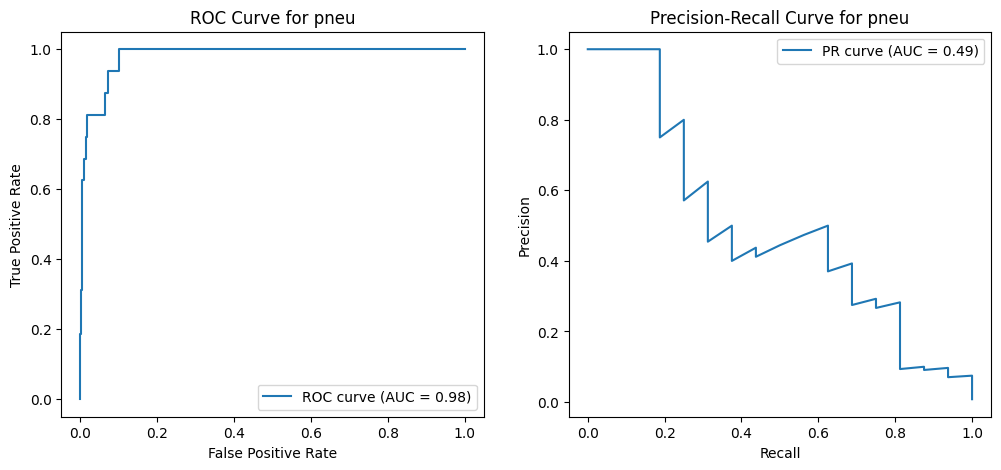

y_train shape: (8000,)
X_train:  779


C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8319 - loss: 0.6847 - val_accuracy: 0.8769 - val_loss: 0.4835
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8944 - loss: 0.3568 - val_accuracy: 0.8969 - val_loss: 0.3585
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8898 - loss: 0.3689 - val_accuracy: 0.8819 - val_loss: 0.3509
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8849 - loss: 0.3401 - val_accuracy: 0.9025 - val_loss: 0.3005
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9064 - loss: 0.3452 - val_accuracy: 0.8994 - val_loss: 0.3319
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9043 - loss: 0.3125 - val_accuracy: 0.8981 - val_loss: 0.3677
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9062 - loss: 0.3232 - val_accuracy: 0.9038 - val_loss: 0.3302
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8007 - loss: 0.5350 - val_accuracy: 0.9050 - val_loss: 0.2833
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9069 - loss: 0.3811 - val_accuracy: 0.8950 - val_loss: 0.2864
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8909 - loss: 0.3504 - val_accuracy: 0.8300 - val_loss: 0.4421
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8577 - loss: 0.3621 - val_accuracy: 0.9044 - val_loss: 0.3043
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9097 - loss: 0.3492 - val_accuracy: 0.9038 - val_loss: 0.2679
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9005 - loss: 0.3273 - val_accuracy: 0.8944 - val_loss: 0.3318
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9039 - loss: 0.3010 - val_accuracy: 0.9137 - val_loss: 0.2892
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8136 - loss: 0.6440 - val_accuracy: 0.8950 - val_loss: 0.3159
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8825 - loss: 0.4059 - val_accuracy: 0.8819 - val_loss: 0.4035
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8867 - loss: 0.3616 - val_accuracy: 0.9119 - val_loss: 0.3065
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8960 - loss: 0.3822 - val_accuracy: 0.9087 - val_loss: 0.3041
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8879 - loss: 0.3500 - val_accuracy: 0.9112 - val_loss: 0.2958
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8948 - loss: 0.3260 - val_accuracy: 0.9056 - val_loss: 0.3247
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9038 - loss: 0.3199 - val_accuracy: 0.9094 - val_loss: 0.3235
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7987 - loss: 0.7553 - val_accuracy: 0.9013 - val_loss: 0.3048
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8777 - loss: 0.3518 - val_accuracy: 0.8963 - val_loss: 0.3202
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8981 - loss: 0.3497 - val_accuracy: 0.9000 - val_loss: 0.3005
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8996 - loss: 0.3286 - val_accuracy: 0.8944 - val_loss: 0.3653
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8914 - loss: 0.3420 - val_accuracy: 0.9056 - val_loss: 0.3366
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8744 - loss: 0.3759 - val_accuracy: 0.9019 - val_loss: 0.3459
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8977 - loss: 0.3708 - val_accuracy: 0.8988 - val_loss: 0.3388
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7989 - loss: 0.6407 - val_accuracy: 0.8950 - val_loss: 0.3237
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8915 - loss: 0.3880 - val_accuracy: 0.9006 - val_loss: 0.3451
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8941 - loss: 0.3907 - val_accuracy: 0.7619 - val_loss: 0.6403
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8353 - loss: 0.3788 - val_accuracy: 0.8706 - val_loss: 0.3813
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8896 - loss: 0.3642 - val_accuracy: 0.8044 - val_loss: 0.6426
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8639 - loss: 0.4059 - val_accuracy: 0.8763 - val_loss: 0.4045
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8917 - loss: 0.3560 - val_accuracy: 0.8763 - val_loss: 0.4464
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accu

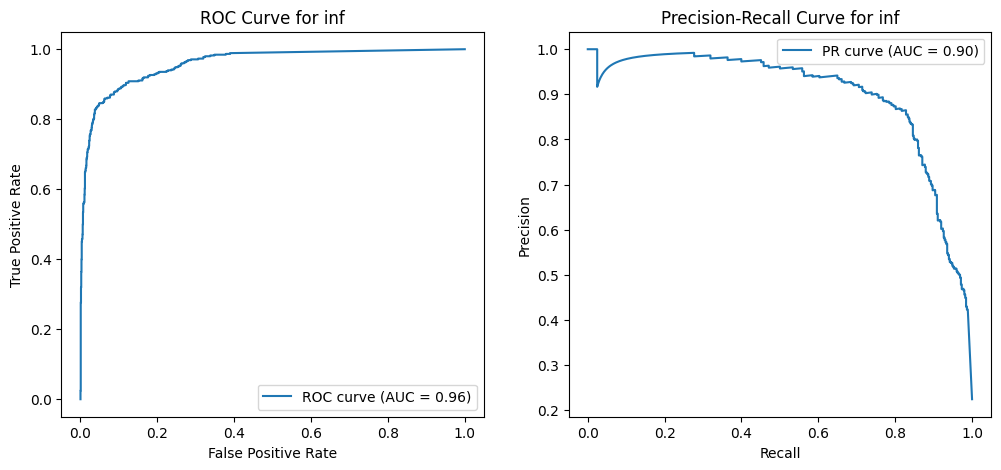

In [ ]:
seeds = [327, 100, 105, 888, 521]
targets = ["pneu", "inf"]

best_models = {}

for target in targets:
    best_auc = -1
    best_model = None
    best_fpr = best_tpr = best_recall = best_precision = None

    for seed in seeds:
        np.random.seed(seed)
        random.seed(seed)
        tf.random.set_seed(seed)

        model, auc_score, fpr, tpr, recall, precision = NN_model_train(target, train_df, test_df)

        if auc_score > best_auc:
            best_auc = auc_score
            best_model = model
            best_fpr = fpr
            best_tpr = tpr
            best_recall = recall
            best_precision = precision

    # Lưu mô hình tốt nhất
    best_models[target] = best_model
    print(f"Best model for '{target}' has ROC AUC = {best_auc:.4f}")

    # Chỉ vẽ đồ thị cho mô hình tốt nhất
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(best_fpr, best_tpr, label=f"ROC curve (AUC = {best_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for " + target)
    plt.legend()

    plt.subplot(1, 2, 2)
    pr_auc = auc(best_recall, best_precision)
    plt.plot(best_recall, best_precision, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for " + target)
    plt.legend()

    plt.show()
